In [1]:
%load_ext autoreload
%autoreload 2

import torch
from cre_reg.experiments import rectangle
import matplotlib.pyplot as plt
import numpy as np

**Create structures and images from uniform latent dimensions.**

In [2]:
n_images_to_create = 3
noise_std = 0.5

latent_widths = torch.arange(n_images_to_create) * .2 + 1
latent_heights = torch.arange(n_images_to_create) * .2 + 2
latent_values = torch.stack([latent_widths, latent_heights], dim=1)

rectangle_model = rectangle.RectangleModel(None, noise_std=noise_std)
raw_images, structures = rectangle_model.render_images_from_latent(latent_values)
clean_images, structures = rectangle_model.render_images_from_latent(latent_values, noise_std=0)


snr = torch.var(clean_images) / noise_std**2
print("Observed Signal to noise ratio:", snr.item())


Observed Signal to noise ratio: 0.10996118932962418


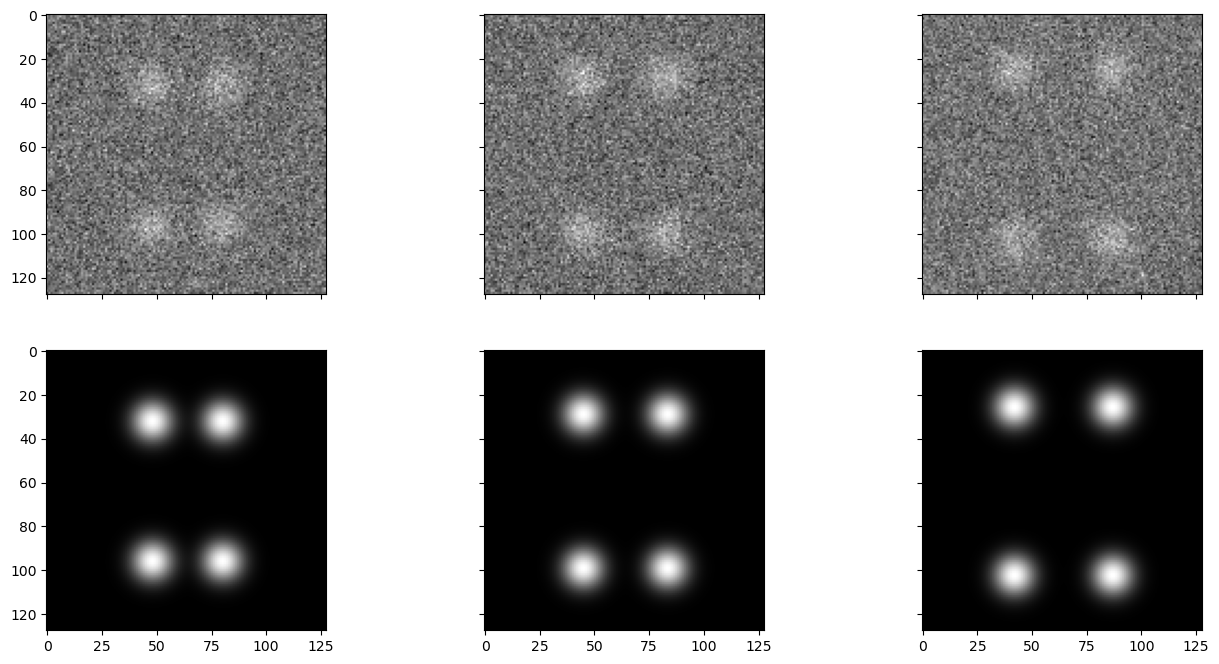

In [3]:
fig, axes = plt.subplots(2, n_images_to_create, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes[0]):
    ax.imshow(raw_images[i], cmap='grey')
for i, ax in enumerate(axes[1]):
    ax.imshow(clean_images[i], cmap='grey')

In [4]:
# Calculate log likelihoods
log_Pij = rectangle_model.evaluate_log_pij_matrix(raw_images, clean_images, noise_std)
print(log_Pij / 128**2)

tensor([[-0.5052, -0.5200, -0.5436],
        [-0.5190, -0.5045, -0.5101],
        [-0.5523, -0.5208, -0.4956]])


**Create images from a Gaussian mixture latent dimension model.**

/home/erik/mambaforge/envs/cryotorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0, 0.5, 'Width')

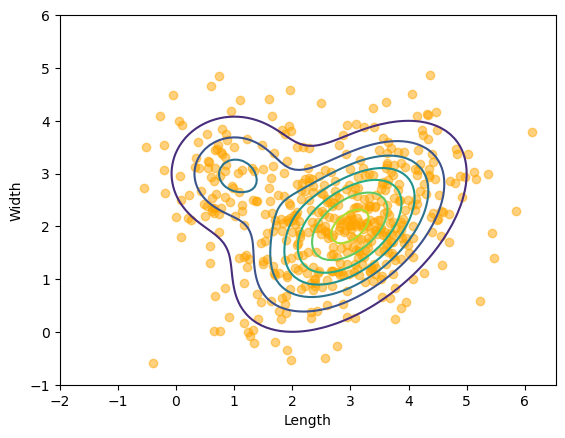

In [5]:
from cre_reg.experiments.rectangle import LatentDimensionsModel
import matplotlib.pyplot as plt
import torch

latent_means = torch.tensor([[1., 3], [3, 2]])
latent_covariances = torch.tensor([
    [[0.5, 0], [0, 0.5]],
    [[1, .5], [.5, 1]],
])
latent_weights = torch.tensor([1, 4]) # Need not be normalized

# Initialize latent length-width model
latent_model = LatentDimensionsModel(length_width_means=latent_means,
                                     length_width_covariances=latent_covariances,
                                     length_width_weights=latent_weights
)

# Plot latent densities along with samples
mesh_size = 100
lengths = torch.linspace(torch.min(latent_means[:, 0]).item()-3, torch.max(latent_means[:, 0]).item()+3, mesh_size)
widths = torch.linspace(torch.min(latent_means[:, 1]).item()-3, torch.max(latent_means[:, 1]).item()+3, mesh_size)
l_grid, w_grid = torch.meshgrid(lengths, widths)

# Compute probability density
lw_grid = torch.cat((l_grid.reshape(-1, 1), w_grid.reshape(-1, 1)), dim=1)
probabilities = torch.tensor([latent_model.evaluate_density(length_width) for length_width in lw_grid]).reshape(mesh_size, mesh_size)

# Generate samples from mixture model
num_samples = 500
lw_samples = latent_model.sample_length_widths(num_samples)

plt.contour(l_grid.numpy(), w_grid.numpy(), probabilities.numpy())
plt.scatter(lw_samples[:, 0], lw_samples[:, 1], color='orange', alpha=0.5)
plt.xlabel("Length"); plt.ylabel("Width")

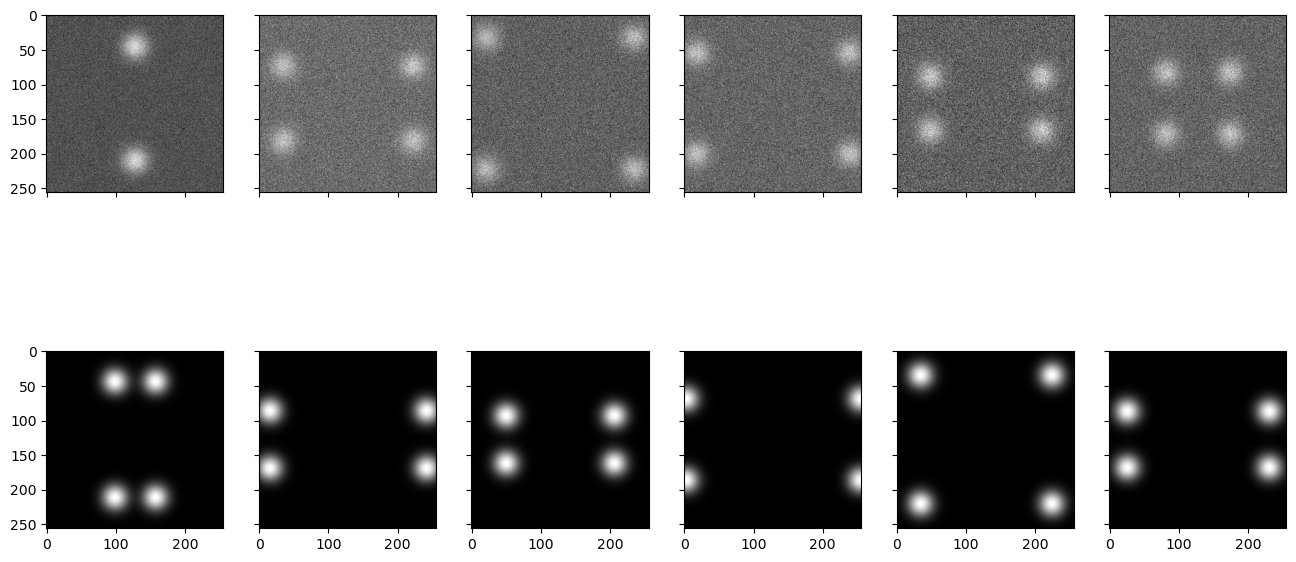

In [6]:
from cre_reg.experiments.rectangle import RectangleModel

# Initialize rectangle models with and without noise.
noise_std = 0.25
image_width = 256
rectangle_model_with_noise = RectangleModel(latent_density=latent_model, image_width_in_pixels=image_width, noise_std=noise_std)
rectangle_model_without_noise = RectangleModel(latent_density=latent_model, image_width_in_pixels=image_width)

# Sample images from above models.
num_structures = 6
images_with_noise, structures, latents = rectangle_model_with_noise.sample_images(num_structures)
images_without_noise, structures, latents = rectangle_model_without_noise.sample_images(num_structures)

# Plot noisy and noiseless images from same latent distribution of lengths and widths.
fig, axes = plt.subplots(nrows=2, ncols=num_structures, sharex=True, sharey=True, figsize=(16, 8))

for i, ax in enumerate(axes[0]):
    ax.imshow(images_with_noise[i], cmap='grey')
for i, ax in enumerate(axes[1]):
    ax.imshow(images_without_noise[i], cmap='grey')